In [2]:
import argparse as ap
from collections import namedtuple
import csv
from enum import Enum
import jax as jax
import jax.numpy as np
import math as math
import matplotlib.pyplot as plt
import numpy as onp
import pandas as pd
import pickle as pl
import random as rand
import time as time

In [524]:
input_mol = "benzene"
input_ticks = 1000000000
dt = 1e-18
energyHistory5 = pd.read_csv(input_mol + '_energyHistory5.csv')
bondHistory5 = pd.read_csv(input_mol + '_bondLengthHistory5.csv')
energyHistory10 = pd.read_csv(input_mol + '_energyHistory10.csv')
bondHistory10 = pd.read_csv(input_mol + '_bondLengthHistory10.csv')
dataLen = energyHistory10["time"].count()
dataLen

500000

In [525]:
def draw_energy(energyHistory, input_mol, input_ticks, dt, q_start, q_end, out_file = None, title = "", prefix = ""):
    dataLen = energyHistory["time"].count()
    font = {'family' : 'DejaVu Sans',
        'size' : min(max(12, dataLen / 300 * (q_end - q_start) / 4), 24)}

    rng = range(int(q_start * dataLen / 4), int(q_end * dataLen / 4))

    plt.figure(figsize = (min(max(10, dataLen / 100 * (q_end - q_start) / 4), 25), 5))
    plt.rc('font', **font)
    plt.plot(energyHistory["time"][rng], energyHistory["potentialE"][rng] * 6.2415090744608, label = 'Potential') #, s = 2.5)
    plt.plot(energyHistory["time"][rng], energyHistory["kineticE"][rng] * 6.2415090744608, label = 'Kinetic') #, s = 2.5)
    plt.plot(energyHistory["time"][rng], (energyHistory["potentialE"][rng] + energyHistory["kineticE"][rng]) * 6.2415090744608, label = 'Total') #, s = 2.5)

    plt.xlim([energyHistory["time"][rng].min(), energyHistory["time"][rng].max()])

    # plt.title(input_mol.capitalize() + " Energy for " + str(input_ticks) + " Ticks" + title_suffix + ", dt = " + str(dt) + "s")
    #plt.title(input_mol.capitalize() + " Energy for " + str(input_ticks) + " Ticks" + title_suffix + ", dt = " + str(dt) + "s")
    if title == "0.10":
        plt.xlabel('Time (ps)')
        plt.xticks(np.arange(0, max(energyHistory["time"][rng]), 0.05))
    else:
        plt.xticks([])
    plt.ylabel('Energy (meV)')
    plt.ylim([0, max((energyHistory["potentialE"][rng])) * 6.2415090744608 * 1.25])
    plt.text(max(energyHistory["time"][rng]) / 128, plt.gca().get_ylim()[1] * 63 / 64, prefix + " r=" + title, fontsize = 24, verticalalignment = 'top')
    # plt.yticks(np.arange(0, 500, max(np.ceil(max(energyHistory["potentialE"][rng]) / 5 * 6.2415090744608 / 50) * 50, 50)))
    plt.legend(prop = {'size' : 24}, markerscale = 5, loc = 1)
    plt.tight_layout()

    if out_file is None:
        plt.figure()
    else:
        plt.savefig(out_file)

In [526]:
def draw_bond(bondHistory, input_mol, input_ticks, dt, q_start, q_end, out_file = None, title = "", prefix = ""):
    dataLen = bondHistory["time"].count()
    font = {'family' : 'DejaVu Sans',
        'size' : min(max(12, dataLen / 750 * (q_end - q_start) / 4), 24)}

    rng = range(int(q_start * dataLen / 4), int(q_end * dataLen / 4))

    plt.figure(figsize = (min(max(10, dataLen / 400 * (q_end - q_start) / 4), 25), 5))
    plt.rc('font', **font)
    plt.plot([bondHistory["time"][int(q_start * dataLen / 4)], bondHistory["time"][int(q_end * dataLen / 4) - 1]], [1.455, 1.455], color = 'blue', linestyle = ':')
    plt.plot([bondHistory["time"][int(q_start * dataLen / 4)], bondHistory["time"][int(q_end * dataLen / 4) - 1]], [1.099, 1.099], color = 'orange', linestyle = ':')

    plt.plot(bondHistory["time"][rng], bondHistory["CC_Bonds"][rng], label = 'Average CC Bond Length') #, s = 2.5)
    plt.plot(bondHistory["time"][rng], bondHistory["CH_Bonds"][rng], label = 'Average CH Bond Length') #, s = 2.5)

    plt.text(max(bondHistory["time"][rng]) / 128, 1.65 * 63 / 64, prefix + " r=" + title, fontsize = 24, verticalalignment = 'top')
    # plt.title("Average " + input_mol.capitalize() + " Bond Lengths for " + str(input_ticks) + " Ticks" + title_suffix + ", dt = " + str(dt) + "s")
    plt.xlim([bondHistory["time"][rng].min(), bondHistory["time"][rng].max()])
    if title == "0.10":
        plt.xlabel('Time (ps)')
        plt.xticks(np.arange(min(bondHistory["time"][rng]), max(bondHistory["time"][rng]), 0.1))
    else:
        plt.xticks([])
    plt.ylim([0.95,1.65])
    plt.ylabel('Bond Length (Å)')
    plt.yticks(np.arange(1, 1.7, 0.1))
    plt.legend(prop = {'size' : 24}, markerscale = 5, loc = 7)
    plt.tight_layout()

    if out_file is None:
        plt.figure()
    else:
        plt.savefig(out_file)

In [527]:
def draw_bond_histogram(bondHistory, input_mol, input_ticks, dt, q_start, q_end, binWidth, out_file = None):
    dataLen = bondHistory["time"].count()
    font = {'family' : 'DejaVu Sans',
        'size' : 12}

    rng = range(int(q_start * dataLen / 4), int(q_end * dataLen / 4))

    plt.figure(figsize = (10, 5))
    plt.rc('font', **font)

    cc_bins = np.arange(min(bondHistory["CC_Bonds"][rng]), max(bondHistory["CC_Bonds"][rng]) + binWidth, binWidth)
    cc_hist = plt.hist(bondHistory["CC_Bonds"][rng], bins = cc_bins, label = 'Average CC Bond Length')

    ch_bins = np.arange(min(bondHistory["CH_Bonds"][rng]), max(bondHistory["CH_Bonds"][rng]) + binWidth, binWidth)
    ch_hist = plt.hist(bondHistory["CH_Bonds"][rng], bins = ch_bins, label = 'Average CH Bond Length')

    maxY = max(np.max(cc_hist[0]), np.max(ch_hist[0]))

    plt.plot([1.455, 1.455], [0, maxY * 1.25], color = 'blue', linestyle = ':')
    plt.plot([1.099, 1.099], [0, maxY * 1.25], color = 'orange', linestyle = ':')

    # plt.title("Histogram of Average " + input_mol.capitalize() + " Bond Lengths Over Time for " + str(input_ticks) + " Ticks, dt = " + str(dt) + "s")
    plt.xlabel('Bond Length (Å)')
    plt.ylabel('Counts')
    plt.legend(prop = {'size' : 24}, loc = 9)
    plt.tight_layout()

    return plt

    # if out_file is None:
    #     plt.figure()
    # else:
    #     plt.savefig(out_file)

In [530]:
def draw_bond_histogram_overlay(bondHistory, input_mol, input_ticks, dt, q_start, q1_end, q2_end, binWidth, out_file = None, title = "", prefix = ""):
    dataLen = bondHistory["time"].count()
    font = {'family' : 'DejaVu Sans',
        'size' : 18}

    rng1 = range(int(q_start * dataLen / 4), int(q1_end * dataLen / 4))
    rng2 = range(int(q_start * dataLen / 4), int(q2_end * dataLen / 4))

    plt.figure(figsize = (10, 5))
    plt.rc('font', **font)

    bins = np.arange(0.95, 1.65 + binWidth, binWidth)
    # cc1_bins = np.arange(min(bondHistory["CC_Bonds"][rng1]), max(bondHistory["CC_Bonds"][rng1]) + binWidth, binWidth)
    cc1_hist = plt.hist(bondHistory["CC_Bonds"][rng1], bins = bins, label = 'Average CC Bond Length (3ps)', color = 'r', alpha = 0.5, density = 1) #, edgecolor = 'black')

    # cc2_bins = np.arange(min(bondHistory["CC_Bonds"][rng2]), max(bondHistory["CC_Bonds"][rng2]) + binWidth, binWidth)
    cc2_hist = plt.hist(bondHistory["CC_Bonds"][rng2], bins = bins, label = 'Average CC Bond Length (1ps)', color = 'b', alpha = 0.5, density = 1) #, edgecolor = 'black')

    # ch1_bins = np.arange(min(bondHistory["CH_Bonds"][rng1]), max(bondHistory["CH_Bonds"][rng1]) + binWidth, binWidth)
    ch1_hist = plt.hist(bondHistory["CH_Bonds"][rng1], bins = bins, label = 'Average CH Bond Length (3ps)', color = 'orange', alpha = 0.5, density = 1) #, edgecolor = 'black')

    # ch2_bins = np.arange(min(bondHistory["CH_Bonds"][rng2]), max(bondHistory["CH_Bonds"][rng2]) + binWidth, binWidth)
    ch2_hist = plt.hist(bondHistory["CH_Bonds"][rng2], bins = bins, label = 'Average CH Bond Length (1ps)', color = 'g', alpha = 0.5, density = 1) #, edgecolor = 'black')

    maxY = max(max(np.max(cc1_hist[0]), np.max(ch1_hist[0])), max(np.max(cc2_hist[0]), np.max(ch2_hist[0])))

    plt.plot([1.455, 1.455], [0, maxY * 1.75], color = 'blue', linestyle = ':')
    plt.plot([1.099, 1.099], [0, maxY * 1.75], color = 'orange', linestyle = ':')

    plt.xlim([0.95,1.65])

    plt.text(0.975, maxY * 1.75, prefix + " r=" + title, fontsize = 18, verticalalignment = 'top')
    # plt.title("Histogram of Average " + input_mol.capitalize() + " Bond Lengths Over Time for " + str(input_ticks) + " Ticks, dt = " + str(dt) + "s")
    plt.xlabel('Bond Length (Å)', fontsize = 21)
    plt.xticks(np.arange(0.95, 1.7, 0.05))
    plt.yticks([])
    plt.legend(prop = {'size' : 18}, loc = 1)
    plt.tight_layout()

    if out_file is None:
        plt.figure()
    else:
        plt.savefig(out_file)

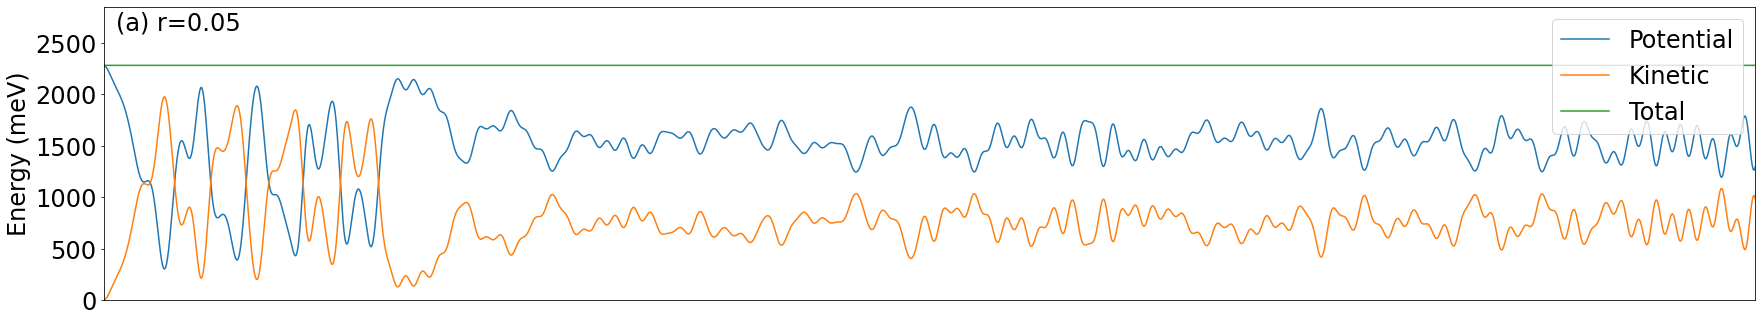

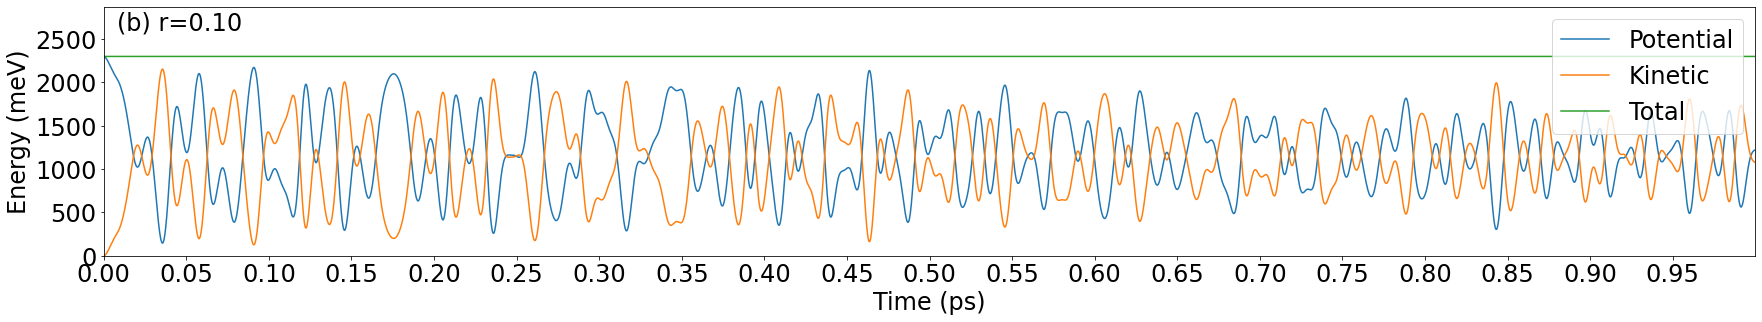

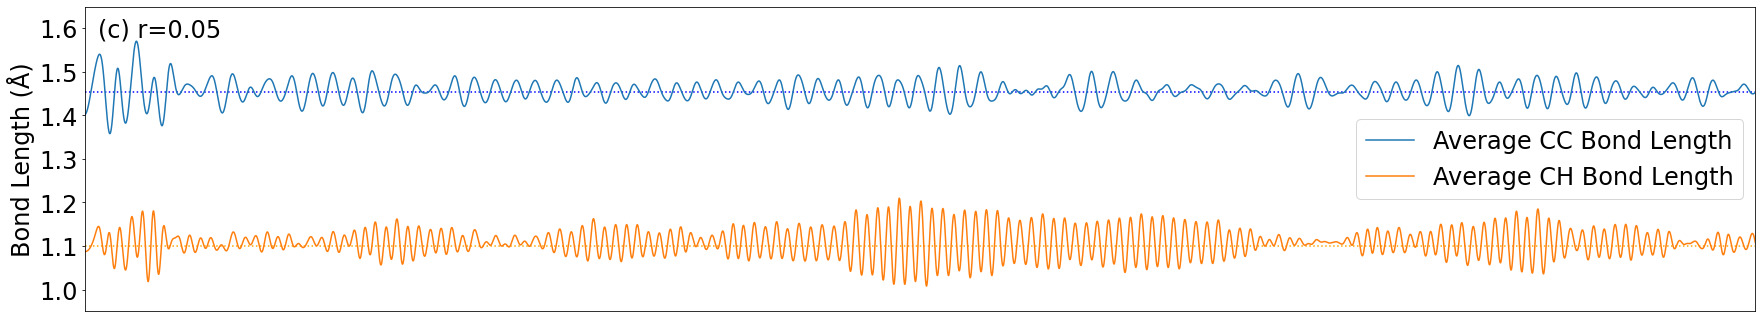

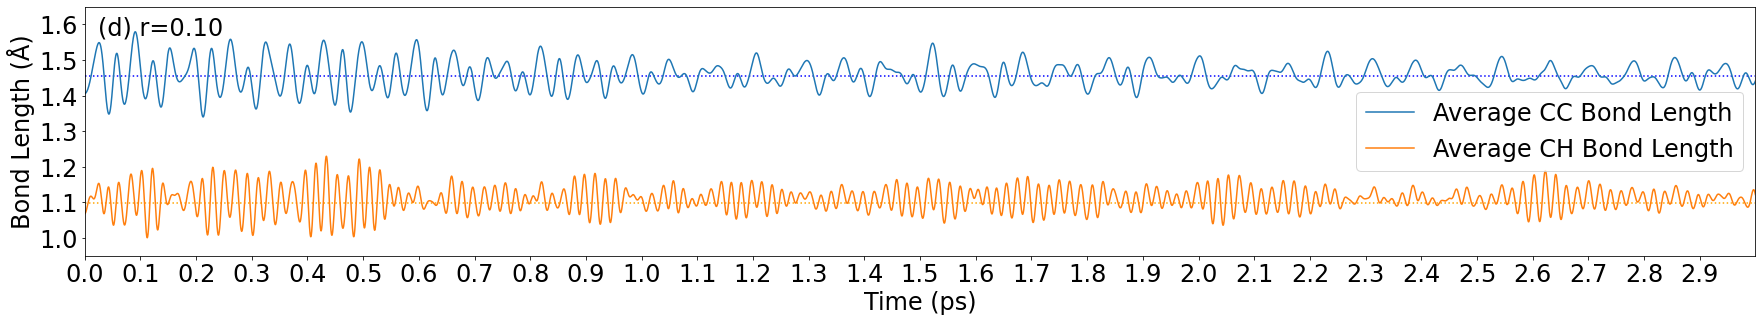

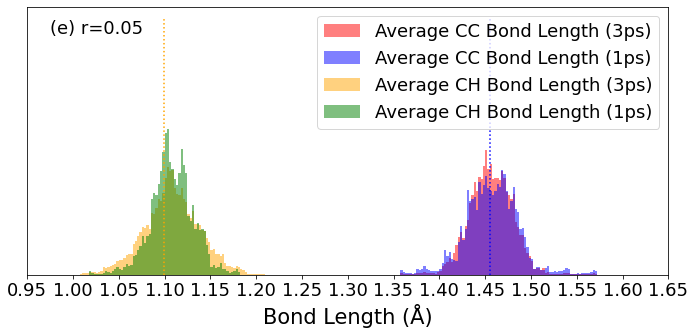

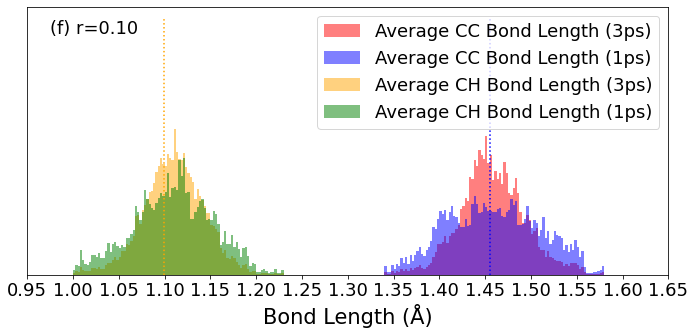

In [531]:
a = 0
b = 0.24
c = 0.08
title5 = "0.05"
title10 = "0.10"

draw_energy(energyHistory5, input_mol, input_ticks, dt, a, c, input_mol + "_energyr5.png", title5, "(a)")
draw_energy(energyHistory10, input_mol, input_ticks, dt, a, c, input_mol + "_energyr10.png", title10, "(b)")
draw_bond(bondHistory5, input_mol, input_ticks, dt, a, b, input_mol + "_bondr5.png", title5, "(c)")
draw_bond(bondHistory10, input_mol, input_ticks, dt, a, b, input_mol + "_bondr10.png", title10, "(d)")
draw_bond_histogram_overlay(bondHistory5, input_mol, input_ticks, dt, a, b, c, 0.0025, input_mol + "_bondHistr5", title5, "(e)")
draw_bond_histogram_overlay(bondHistory10, input_mol, input_ticks, dt, a, b, c, 0.0025, input_mol + "_bondHistr10", title10, "(f)")

# draw_bond_histogram(bondHistory, input_mol, input_ticks, dt, a, b, 0.001, input_mol + "_bondHistr3ps05")
# draw_bond_histogram(bondHistory, input_mol, input_ticks, dt, a, c, 0.001, input_mol + "_bondHistr1ps05")